## Gaussian Mixture Model (GMM) Algorithm Implementation

In [1]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as SklearnGMM
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os

In [2]:
# Create the results directory if it doesn't exist
results_directory = "./../results"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
    
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"


In [3]:
# Read datasets into pandas DataFrames
iris_data = pd.read_csv(iris_dataset_path)
ai_index_data = pd.read_csv(ai_global_index_path)
earthquake_data = pd.read_csv(global_earthquake_data_path)

# Dictionary to hold datasets
datasets = {
    "iris": iris_data,
    "ai_global_index": ai_index_data,
    "global_earthquake": earthquake_data
}

In [7]:
# Custom Gaussian Mixture Model (GMM) Implementation
class CustomGMM:
    def __init__(self, num_components=3, max_iterations=100, tolerance=1e-4, reg_covar=1e-6):
        """
        Initialize Gaussian Mixture Model (GMM).

        Parameters:
        - num_components: Number of Gaussian components (default: 3).
        - max_iterations: Maximum number of iterations (default: 100).
        - tolerance: Convergence threshold (default: 1e-4).
        - reg_covar: Regularization term for covariance matrices (default: 1e-6).
        """
        self.num_components = num_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.reg_covar = reg_covar
        self.weights = None
        self.means = None
        self.covariances = None
        self.responsibilities = None

    def fit(self, data):
        """
        Fit the GMM to the dataset using the EM algorithm.

        Parameters:
        - data: Input data (numpy array or pandas DataFrame).
        """
        num_samples, num_features = data.shape

        # Step 1: Initialize mixture parameters
        self.weights = np.ones(self.num_components) / self.num_components  # Mixing coefficients
        self.means = data[np.random.choice(num_samples, self.num_components, replace=False)]  # Means
        self.covariances = [np.eye(num_features) for _ in range(self.num_components)]  # Covariance matrices

        log_likelihood_old = 0

        for iteration in range(self.max_iterations):
            # Step 2: E-step (Expectation)
            # Compute posterior probabilities (responsibilities)
            self.responsibilities = self._compute_responsibilities(data)

            # Step 3: M-step (Maximization)
            # Update mixture parameters
            self._update_parameters(data)

            # Step 4: Compute log-likelihood
            log_likelihood_new = self._compute_log_likelihood(data)

            # Step 5: Check for convergence
            if abs(log_likelihood_new - log_likelihood_old) < self.tolerance:
                break

            log_likelihood_old = log_likelihood_new

    def _compute_responsibilities(self, data):
        """
        Compute the posterior probabilities (responsibilities).

        Parameters:
        - data: Input data.

        Returns:
        - responsibilities: Posterior probabilities for each data point and component.
        """
        num_samples = data.shape[0]
        responsibilities = np.zeros((num_samples, self.num_components))

        for k in range(self.num_components):
            responsibilities[:, k] = self.weights[k] * self._gaussian_pdf(data, self.means[k], self.covariances[k])

        # Normalize responsibilities
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def _gaussian_pdf(self, data, mean, covariance):
        """
        Compute the Gaussian probability density function (PDF).

        Parameters:
        - data: Input data.
        - mean: Mean of the Gaussian.
        - covariance: Covariance matrix of the Gaussian.

        Returns:
        - pdf: Gaussian PDF values.
        """
        num_features = data.shape[1]
        diff = data - mean
        covariance_reg = covariance + self.reg_covar * np.eye(num_features)  # Regularize covariance
        exponent = -0.5 * np.sum(diff @ np.linalg.inv(covariance_reg) * diff, axis=1)
        normalization = 1 / np.sqrt((2 * np.pi) ** num_features * np.linalg.det(covariance_reg))
        return np.clip(normalization * np.exp(exponent), a_min=1e-10, a_max=None)  # Clip to avoid zero

    def _update_parameters(self, data):
        """
        Update the mixture parameters (weights, means, covariances).

        Parameters:
        - data: Input data.
        """
        num_samples = data.shape[0]

        # Update weights
        self.weights = np.mean(self.responsibilities, axis=0)

        # Update means
        self.means = np.zeros((self.num_components, data.shape[1]))
        for k in range(self.num_components):
            self.means[k] = np.sum(self.responsibilities[:, k, np.newaxis] * data, axis=0) / np.sum(self.responsibilities[:, k])

        # Update covariances
        self.covariances = [np.zeros((data.shape[1], data.shape[1])) for _ in range(self.num_components)]
        for k in range(self.num_components):
            diff = data - self.means[k]
            self.covariances[k] = (self.responsibilities[:, k, np.newaxis] * diff).T @ diff / np.sum(self.responsibilities[:, k])

    def _compute_log_likelihood(self, data):
        """
        Compute the log-likelihood of the data.

        Parameters:
        - data: Input data.

        Returns:
        - log_likelihood: Log-likelihood value.
        """
        log_likelihood = 0
        for k in range(self.num_components):
            pdf_values = self.weights[k] * self._gaussian_pdf(data, self.means[k], self.covariances[k])
            log_likelihood += np.sum(self.responsibilities[:, k] * np.log(np.clip(pdf_values, a_min=1e-10, a_max=None)))  # Clip to avoid log(0)
        return log_likelihood

    def predict(self, data):
        """
        Predict the cluster assignments for each data point.

        Parameters:
        - data: Input data.

        Returns:
        - labels: Cluster assignments.
        """
        responsibilities = self._compute_responsibilities(data)
        return np.argmax(responsibilities, axis=1)
    
# Function to evaluate clustering performance
def evaluate_clustering(data, labels):
    """
    Evaluate clustering performance using metrics.

    Parameters:
    - data: Input data.
    - labels: Cluster labels.

    Returns:
    - silhouette_score: Measures how similar an object is to its own cluster.
    - davies_bouldin_score: Evaluates clustering quality based on scatter and separation.
    - calinski_harabasz_score: Measures the ratio of between-cluster dispersion to within-cluster dispersion.
    """
    if len(np.unique(labels)) < 2:
        print("Warning: Only one cluster found. Skipping evaluation.")
        return np.nan, np.nan, np.nan

    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    return silhouette, davies_bouldin, calinski_harabasz



Processing iris dataset
Custom GMM Metrics for iris:
Silhouette Score: 0.3217, Davies-Bouldin Index: 1.4714, Calinski-Harabasz Index: 149.8326
Sklearn GMM Metrics for iris:
Silhouette Score: 0.4092, Davies-Bouldin Index: 0.8669, Calinski-Harabasz Index: 133.7028


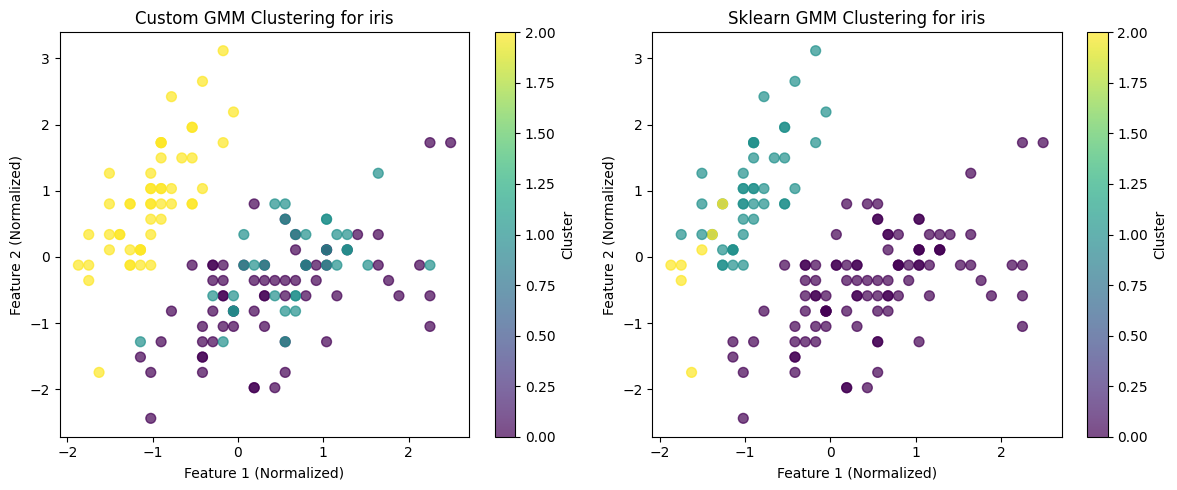


Processing ai_global_index dataset
Custom GMM Metrics for ai_global_index:
Silhouette Score: 0.1446, Davies-Bouldin Index: 1.6601, Calinski-Harabasz Index: 15.2839
Sklearn GMM Metrics for ai_global_index:
Silhouette Score: 0.2706, Davies-Bouldin Index: 0.8910, Calinski-Harabasz Index: 34.2636


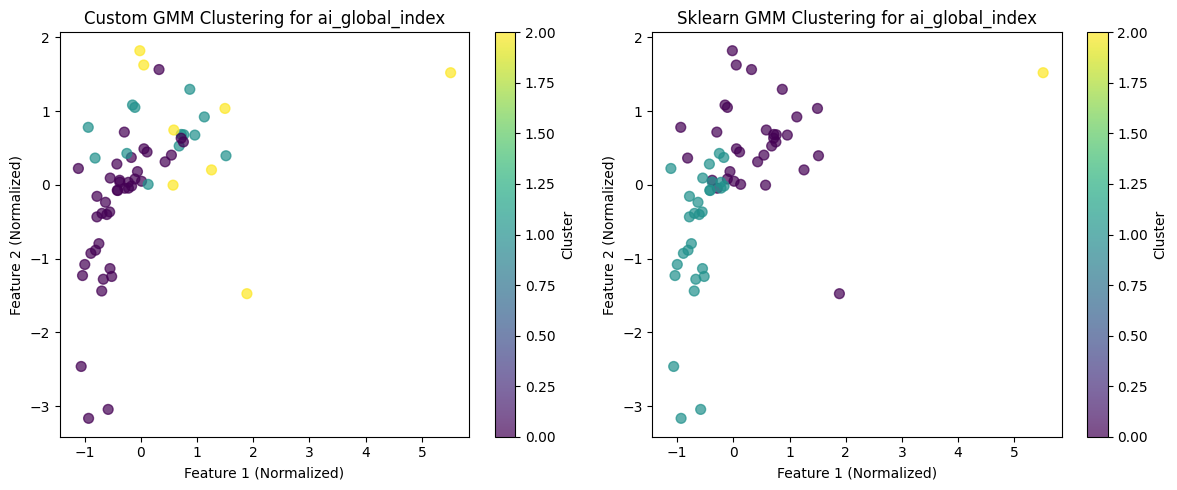


Processing global_earthquake dataset
Custom GMM Metrics for global_earthquake:
Silhouette Score: 0.0622, Davies-Bouldin Index: 3.6127, Calinski-Harabasz Index: 4.2481
Sklearn GMM Metrics for global_earthquake:
Silhouette Score: 0.2137, Davies-Bouldin Index: 1.6484, Calinski-Harabasz Index: 14.5256


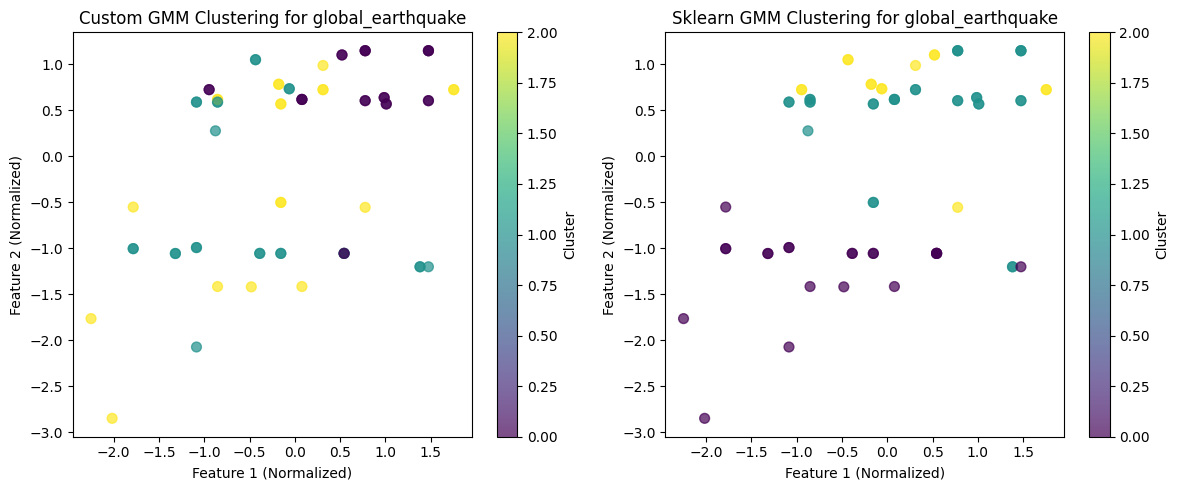

In [8]:
# Process datasets
results = {}

for dataset_name, dataset in datasets.items():
    print(f"\nProcessing {dataset_name} dataset")

    # Handle missing values
    dataset = dataset.dropna()  # Remove rows with missing values

    # Select only numeric columns
    numeric_data = dataset.select_dtypes(include=[np.number]).values

    # Normalize data
    normalized_data = StandardScaler().fit_transform(numeric_data)

    # Run custom GMM
    custom_gmm = CustomGMM(num_components=3, max_iterations=100, tolerance=1e-4, reg_covar=1e-6)
    custom_gmm.fit(normalized_data)
    custom_labels = custom_gmm.predict(normalized_data)

    # Run sklearn GMM
    sklearn_gmm = SklearnGMM(n_components=3, max_iter=100, tol=1e-4, random_state=42)
    sklearn_gmm.fit(normalized_data)
    sklearn_labels = sklearn_gmm.predict(normalized_data)

    # Evaluate clustering performance
    custom_metrics = evaluate_clustering(normalized_data, custom_labels)
    sklearn_metrics = evaluate_clustering(normalized_data, sklearn_labels)

    # Save results
    results[dataset_name] = {
        "custom_silhouette": custom_metrics[0],
        "custom_davies_bouldin": custom_metrics[1],
        "custom_calinski_harabasz": custom_metrics[2],
        "sklearn_silhouette": sklearn_metrics[0],
        "sklearn_davies_bouldin": sklearn_metrics[1],
        "sklearn_calinski_harabasz": sklearn_metrics[2]
    }

    # Print results
    print(f"Custom GMM Metrics for {dataset_name}:")
    print(f"Silhouette Score: {custom_metrics[0]:.4f}, Davies-Bouldin Index: {custom_metrics[1]:.4f}, Calinski-Harabasz Index: {custom_metrics[2]:.4f}")
    print(f"Sklearn GMM Metrics for {dataset_name}:")
    print(f"Silhouette Score: {sklearn_metrics[0]:.4f}, Davies-Bouldin Index: {sklearn_metrics[1]:.4f}, Calinski-Harabasz Index: {sklearn_metrics[2]:.4f}")

    # Visualize clusters
    plt.figure(figsize=(12, 5))

    # Plot Custom GMM clusters
    plt.subplot(1, 2, 1)
    plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=custom_labels, cmap="viridis", s=50, alpha=0.7)
    plt.title(f"Custom GMM Clustering for {dataset_name}")
    plt.xlabel("Feature 1 (Normalized)")
    plt.ylabel("Feature 2 (Normalized)")
    plt.colorbar(label="Cluster")

    # Plot Sklearn GMM clusters
    plt.subplot(1, 2, 2)
    plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=sklearn_labels, cmap="viridis", s=50, alpha=0.7)
    plt.title(f"Sklearn GMM Clustering for {dataset_name}")
    plt.xlabel("Feature 1 (Normalized)")
    plt.ylabel("Feature 2 (Normalized)")
    plt.colorbar(label="Cluster")

    plt.tight_layout()
    plt.show()


In [9]:
# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("./../results/gmm_results.csv")